In [37]:
!pip install facenet-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 51.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 89.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 100.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 65.8 MB/s eta 0:00:00:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 20.4 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 12.8 MB/s eta 0:00:0000:01m00:01
   ━━━━━━━━━━━━━━━━━━━━━

In [46]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from facenet_pytorch import InceptionResnetV1, MTCNN

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize MTCNN for face detection
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

# Initialize pre-trained model
face_embedder = InceptionResnetV1(pretrained='vggface2').eval().to(device)

def detect_face_mtcnn(img):
    """Detect face using MTCNN and return cropped face"""
    img_np = np.array(img)
    
    # Detect face
    boxes, _ = mtcnn.detect(img_np)
    
    if boxes is not None and len(boxes) > 0:
        # Get the first face
        x1, y1, x2, y2 = boxes[0].astype(int)
        
        # Expand the bounding box slightly
        margin = 0.2
        width = x2 - x1
        height = y2 - y1
        x1 = max(0, x1 - margin * width)
        y1 = max(0, y1 - margin * height)
        x2 = min(img_np.shape[1], x2 + margin * width)
        y2 = min(img_np.shape[0], y2 + margin * height)
        
        # Crop the face
        face = img_np[int(y1):int(y2), int(x1):int(x2)]
        return Image.fromarray(face)
    return img

# Transformations
transform = transforms.Compose([
    transforms.Lambda(lambda img: detect_face_mtcnn(img)),
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Dataset Class
class FaceVerificationDataset(Dataset):
    def __init__(self, root_dir, transform=None, pairs_per_identity=5):
        self.root_dir = root_dir
        self.transform = transform
        self.identity_folders = [os.path.join(root_dir, f) for f in os.listdir(root_dir) 
                               if os.path.isdir(os.path.join(root_dir, f))]
        self.pairs = self._generate_pairs(pairs_per_identity)

    def _generate_pairs(self, pairs_per_identity):
        pairs = []
        id_images = {}
        
        # Collect all images per identity
        for folder in self.identity_folders:
            id_name = os.path.basename(folder)
            id_images[id_name] = []
            
            # Add frontal image
            frontal_img = os.path.join(folder, f"{id_name}.jpg")
            if os.path.exists(frontal_img):
                id_images[id_name].append(frontal_img)
            
            # Add distortions
            distortion_dir = os.path.join(folder, "distortion")
            if os.path.exists(distortion_dir):
                for img in os.listdir(distortion_dir):
                    id_images[id_name].append(os.path.join(distortion_dir, img))
        
        # Generate balanced positive and negative pairs
        ids = list(id_images.keys())
        for id_name, images in id_images.items():
            if len(images) < 2:
                continue
                
            # Positive pairs
            for _ in range(pairs_per_identity):
                img1, img2 = random.sample(images, 2)
                pairs.append((img1, img2, 1))  # 1 = same identity
            
            # Negative pairs
            for _ in range(pairs_per_identity):
                other_id = random.choice([i for i in ids if i != id_name])
                if not id_images[other_id]:
                    continue
                img1 = random.choice(images)
                img2 = random.choice(id_images[other_id])
                pairs.append((img1, img2, 0))  # 0 = different identity
        
        return pairs

    def __getitem__(self, index):
        img1_path, img2_path, label = self.pairs[index]
        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float32)

    def __len__(self):
        return len(self.pairs)

# Visualization and evaluation functions
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Match', 'Match'],
                yticklabels=['No Match', 'Match'])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def print_metrics(metrics, title="Metrics"):
    print(f"\n{title}:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-Score: {metrics['f1']:.4f}")

def evaluate_model(model, dataloader, threshold=0.7):
    model.eval()
    y_true = []
    y_pred = []
    distances = []
    
    with torch.no_grad():
        for img1, img2, label in tqdm(dataloader, desc="Evaluating"):
            img1, img2 = img1.to(device), img2.to(device)
            emb1 = model(img1)
            emb2 = model(img2)
            
            # Calculate cosine distance
            cos_distance = 1 - F.cosine_similarity(emb1, emb2).cpu().numpy()
            preds = (cos_distance < threshold).astype(int)
            
            y_true.extend(label.cpu().numpy())
            y_pred.extend(preds)
            distances.extend(cos_distance)
    
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'distances': distances
    }
    return metrics, y_true, y_pred

def plot_distance_distribution(distances, y_true, threshold=0.7):
    plt.figure(figsize=(10, 5))
    
    distances = np.array(distances)
    y_true = np.array(y_true)
    
    plt.hist(distances[y_true == 1], bins=30, alpha=0.5, label='Genuine Pairs')
    plt.hist(distances[y_true == 0], bins=30, alpha=0.5, label='Impostor Pairs')
    
    plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
    plt.title("Face Verification Distance Distribution")
    plt.xlabel("Cosine Distance")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

Evaluating on training set...


Evaluating: 100%|██████████| 549/549 [38:31<00:00,  4.21s/it]



Training Metrics:
Accuracy: 0.8111
Precision: 0.9209
Recall: 0.6807
F1-Score: 0.7828


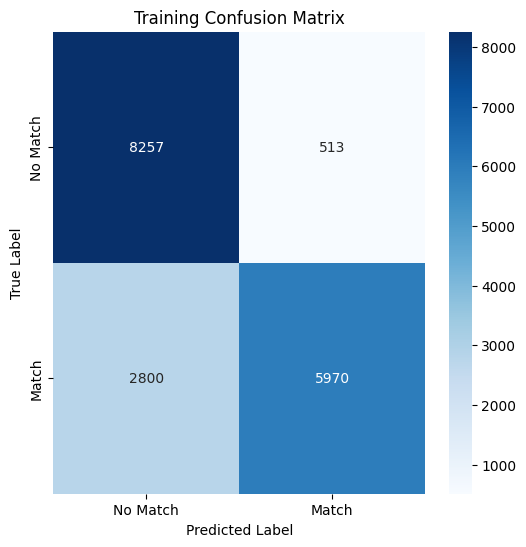

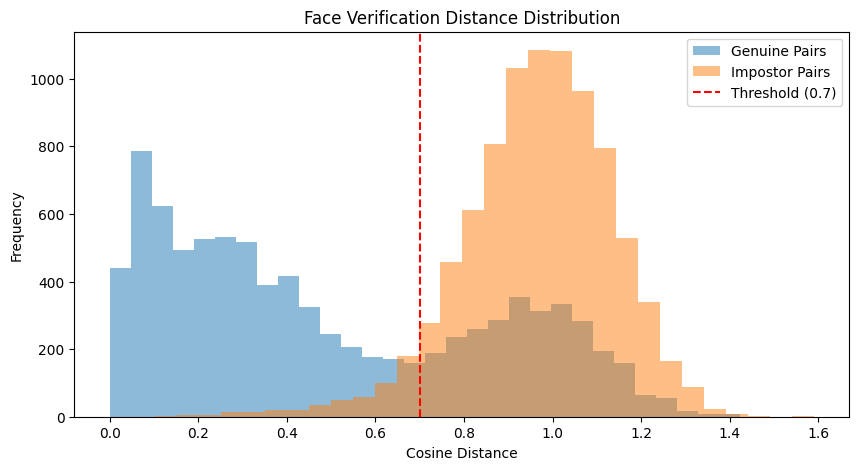


Evaluating on validation set...


Evaluating: 100%|██████████| 79/79 [05:55<00:00,  4.51s/it]


Validation Metrics:
Accuracy: 0.8256
Precision: 0.9257
Recall: 0.7080
F1-Score: 0.8024


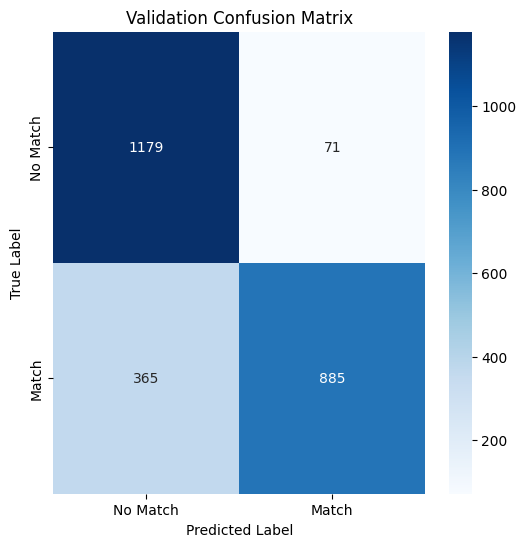

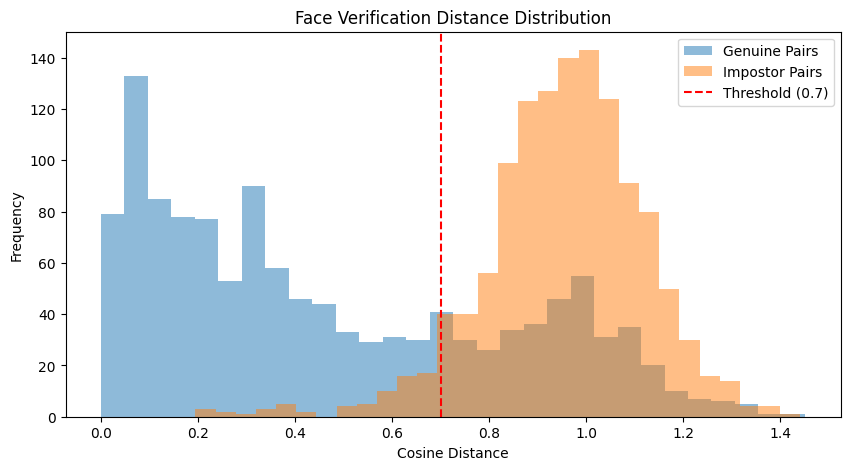


Running example verification...


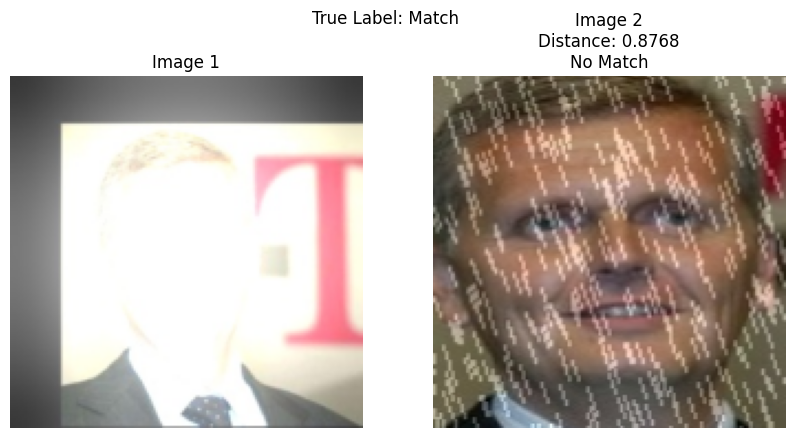

In [ ]:
if __name__ == "__main__":
    # Paths of the data
    train_dir = "/kaggle/input/hackathon-dataset-new/Comys_Hackathon5/Task_B/train"
    val_dir = "/kaggle/input/hackathon-dataset-new/Comys_Hackathon5/Task_B/val"
    
    # Create datasets
    train_dataset = FaceVerificationDataset(train_dir, transform, pairs_per_identity=10)
    val_dataset = FaceVerificationDataset(val_dir, transform, pairs_per_identity=5)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    # Evaluate on training set
    print("Evaluating on training set...")
    train_metrics, train_true, train_pred = evaluate_model(face_embedder, train_loader)
    print_metrics(train_metrics, "Training Metrics")
    plot_confusion_matrix(train_metrics['confusion_matrix'], "Training Confusion Matrix")
    plot_distance_distribution(train_metrics['distances'], train_true)
    
    # Evaluate on validation set
    print("\nEvaluating on validation set...")
    val_metrics, val_true, val_pred = evaluate_model(face_embedder, val_loader)
    print_metrics(val_metrics, "Validation Metrics")
    plot_confusion_matrix(val_metrics['confusion_matrix'], "Validation Confusion Matrix")
    plot_distance_distribution(val_metrics['distances'], val_true)
    
    # Example verification
    print("\nRunning example verification...")
    sample_idx = 0
    img1, img2, label = val_dataset[sample_idx]
    
    face_embedder.eval()
    with torch.no_grad():
        emb1 = face_embedder(img1.unsqueeze(0).to(device))
        emb2 = face_embedder(img2.unsqueeze(0).to(device))
        distance = 1 - F.cosine_similarity(emb1, emb2).item()
        is_match = distance < 0.7
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img1.permute(1, 2, 0).numpy() * 0.5 + 0.5)
    plt.title("Image 1")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img2.permute(1, 2, 0).numpy() * 0.5 + 0.5)
    plt.title(f"Image 2\nDistance: {distance:.4f}\n{'Match' if is_match else 'No Match'}")
    plt.axis('off')
    
    plt.suptitle(f"True Label: {'Match' if label == 1 else 'No Match'}")
    plt.show()